In [1]:
import realspace_tb as tb
import numpy as np
from lattice import *
import os
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from typing import Optional

In [5]:
tb.backend.set_backend(precision="double")

H = tb.LinearFieldHamiltonian(
    tb.HoneycombLatticeGeometry(10, 20),
    tb.RampedACFieldAmplitude(1, 1, 1, np.array([1, 0]))
)

rho = H.ground_state_density_matrix(fermi_level=0.0)
print(rho.dtype)

tb.RK4NeumannSolver().evolve(rho, H, dt=0.001, total_time=10.0)
print(rho.dtype)
print(H.at_time(1).dtype)
print(H.field_amplitude.at_time(1).dtype)

1.0 <class 'numpy.float64'>
Calculating eigenvalues at t=0...
complex128


100%|██████████| 10000/10000 [00:19<00:00, 508.96it/s]

complex128
float64
float64


In [ ]:
class OrbitalPolarisationWithShape(Observable):
    def __init__(
        self,
        site_positions: NDArray[np.float64],
        curl_origin: NDArray[np.float64],
        N,
        n_steps: int,
        cell_anchor_sites: NDArray[np.int64],
        cell_path_offsets: NDArray[np.int64],  # (L, 2) with (di,dj)
        t_hop: float = 1.0,
        m: float = 1.0,
        a_nn: float = 1.0,
        Area: float = 1.0,
        sample_every: Optional[int] = None,
    ) -> None:
        self._pos_np = np.asarray(site_positions, dtype=np.float64)
        self._curl_origin_np = np.asarray(curl_origin, dtype=np.float64)
        self._anchors_np = np.asarray(cell_anchor_sites, dtype=np.int64)
        self._path_np = np.asarray(cell_path_offsets, dtype=np.int64)
        self._sample_every = sample_every
        self.t_hop = float(t_hop)
        self._m = float(m)
        self._a_nn = float(a_nn)
        self._A = float(Area)

        # Precompute edge index pairs and corresponding H values on CPU (small)
        n_cells = self._anchors_np.shape[0]
        L = self._path_np.shape[0]
        rows = np.empty((n_cells, L), dtype=np.int64)
        cols = np.empty((n_cells, L), dtype=np.int64)
        for k, (di, dj) in enumerate(self._path_np):
            rows[:, k] = self._anchors_np + di
            cols[:, k] = self._anchors_np + dj
        self._rows_np = rows
        self._cols_np = cols
        # Edge vectors (CPU, will be moved to GPU in setup): r_k - r_l per (cell, edge)
        pos_cpu = self._pos_np
        self._edge_vecs_np = pos_cpu[self._rows_np] - pos_cpu[self._cols_np]  # (n_cells, L, 2)

        # Normalisation by number of sites (optional)
        self._N = N
        # Move geometry and pre-gathered data to GPU
        self._pos = self._pos_np
        self._curl_origin = self._curl_origin_np
        self._rows = self._rows_np
        self._cols = self._cols_np
        # Edge vectors and their 90° rotation R @ (r_k - r_l)
        self._edge_vecs = self._edge_vecs_np
        # R @ v = [-v_y, v_x]
        self._rot_edge_vecs = np.stack(
            (-self._edge_vecs[..., 1], self._edge_vecs[..., 0]), axis=-1
        )  # (n_cells, L, 2)
        # Per-cell centers using anchor site positions
        self._anchors = self._anchors_np
        self._cell_pos = self._pos[self._anchors]
        # Storage for results
        self._values = np.empty((n_steps, 2))
        self._index = 0

    def measure(self, density_gpu: np.ndarray, step: int) -> None:
        if self._sample_every and step % self._sample_every != 0:
            return
        # Bond currents along the oriented loop edges for each cell
        # I_ij = 2 * t_hop * Im(rho_ij)
        rho_ij = density_gpu[self._rows, self._cols]  # shape (n_cells, L)
        I_edges = 2.0 * self.t_hop * np.imag(rho_ij)
        # Term 1: (9/4) * R_i * sum_edges I_edge per cell
        curl_per_cell = np.sum(I_edges, axis=1)  # (n_cells,)
        centered = self._cell_pos - self._curl_origin  # (n_cells, 2)
        term1_vec = centered.T @ curl_per_cell  # (2,)
        # Term 2: -(5*sqrt(3)/16) * sum_edges [ R @ (r_k - r_l) * I_edge ] over cells
        weighted_rot_edges = (I_edges[..., None] * self._rot_edge_vecs).sum(axis=1)  # (n_cells, 2)
        term2_vec = np.sum(weighted_rot_edges, axis=0)  # (2,)
        # Combine with overall factor -m * a_nn^4
        coeff = -self._m * (self._a_nn ** 2)
        c1 = coeff * (np.sqrt(3.0) / 2.0)
        c2 = coeff * (-5.0 / 24.0)
        P_vec = c1 * term1_vec + c2 * term2_vec
        # Optional normalisation by Area to keep scale comparable with other observables
        P_vec = P_vec / self._A
        self._values[self._index, :] = P_vec
        self._index += 1

    @property
    def values(self):
        return self._values[: self._index]



In [2]:
# Piecewise test of new and old api. First, lets create two lattices
def two_lattices(Lx, Ly, omega, T, T_ramp=6*np.pi):
    field_gen = FieldAmplitudeGenerator.ramped_oscillation(amplitude=1e-3, omega=omega, ramp_width=T_ramp)
    geometry = HexagonalLatticeGeometry((Lx, Ly))
    edges = np.array(geometry.edges)
    substeps = 25

    params = SimulationParameters(
        t_hop=-1.0,
        E_amplitude=field_gen,
        E_direction=np.array([0, 1]),
        h=1.0/omega,
        T=T + T_ramp,
        substeps=substeps,
        initial_occupation=0.5
    )

    l = Lattice2D(geometry, params)

    H = tb.LinearFieldHamiltonian(
        tb.HoneycombLatticeGeometry(Lx, Ly),
        tb.RampedACFieldAmplitude(1e-3, omega, T_ramp, np.array([0, -1]))
    )
    
    return l, H

In [10]:
tb.backend.set_backend(precision="single")
H.at_time(1.0)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 104 stored elements and shape (30, 30)>

In [9]:
l, H = two_lattices(5, 6, omega=10.0, T=5*np.pi)

for t in np.linspace(0, 10*np.pi, 28):
    H1 = H.at_time(t).toarray()
    H2 = l.H(t)

    # print norm of differnce
    diff = np.linalg.norm(H1 - H2)
    print(f"t={t:.2f}, ||H1 - H2|| = {diff:.6e}")

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.
t=0.00, ||H1 - H2|| = 0.000000e+00
t=1.16, ||H1 - H2|| = 0.000000e+00
t=2.33, ||H1 - H2|| = 0.000000e+00
t=3.49, ||H1 - H2|| = 0.000000e+00
t=4.65, ||H1 - H2|| = 0.000000e+00
t=5.82, ||H1 - H2|| = 3.651645e-19
t=6.98, ||H1 - H2|| = 4.515250e-19
t=8.14, ||H1 - H2|| = 0.000000e+00
t=9.31, ||H1 - H2|| = 0.000000e+00
t=10.47, ||H1 - H2|| = 0.000000e+00
t=11.64, ||H1 - H2|| = 0.000000e+00
t=12.80, ||H1 - H2|| = 0.000000e+00
t=13.96, ||H1 - H2|| = 0.000000e+00
t=15.13, ||H1 - H2|| = 0.000000e+00
t=16.29, ||H1 - H2|| = 0.000000e+00
t=17.45, ||H1 - H2|| = 0.000000e+00
t=18.62, ||H1 - H2|| = 0.000000e+00
t=19.78, ||H1 - H2|| = 0.000000e+00
t=20.94, ||H1 - H2|| = 0.000000e+00
t=22.11, ||H1 - H2|| = 0.000000e+00
t=23.27, ||H1 - H2|| = 0.000000e+00
t=24.43, ||H1 - H2|| = 0.000000e+00
t=25.60, ||H1 - H2|| = 0.000000e+00
t=26.76, ||H1 - H2|| = 0.000000e+00
t=27.93, ||H1 - H2|| = 0.000000e+00
t=29.09, ||H1 - H2|| = 0.000000e+00
t

In [20]:
# Now, compare rho(t=0)
print(np.linalg.norm(l.density_matrix - H.ground_state_density_matrix(0.0)))

Calculating eigenvalues at t=0...
4.715638422131487e-11


In [5]:
# Now evolve both and compare
rho = H.ground_state_density_matrix(0.0)
tb.RK4NeumannSolver().evolve(rho, H, dt=0.004, total_time=11*np.pi)

l.evolve()

print(np.linalg.norm(l.states[-1] - rho))

Calculating eigenvalues at t=0...


100%|██████████| 8639/8639 [00:05<00:00, 1701.12it/s]

8.794984327258893e-07


In [ ]:
# So far, the two implementations agree very well! Since fermi level and time step calculation are slightly different, a small difference is expected.

In [6]:
# Lets compare the orbital polarization implementations.

obs = tb.OrbitalPolarizationHoneycomb(H.geometry)

# random complex matrix
N = H.geometry.Lx * H.geometry.Ly
#rho = np.random.rand(N, N) + 1j * np.random.rand(N, N)#
#rho = (rho + rho.conj().T) / 2  # make it Hermitian

rho = H.ground_state_density_matrix(0.0)
tb.RK4NeumannSolver().evolve(rho, H, dt=0.004, total_time=11*np.pi, observables=[obs])


obs2 = OrbitalPolarisationWithShape(
        site_positions=np.array([l.geometry.site_to_position(i) for i in range(l.N)]),
        curl_origin=H.geometry.origin,
        N=l.N,
        n_steps=20000, 
        cell_anchor_sites=np.array(l.geometry.get_curl_sites()),
        cell_path_offsets=np.array([(0, 1), (1, 2), (2, l.Lx + 2), (l.Lx + 2, l.Lx + 1), (l.Lx + 1, l.Lx), (l.Lx, 0)]),
        t_hop=1.0,
        m=0.741, # electron mass in natural units
        a_nn=1.0,
        Area=len(l.geometry.get_curl_sites())*3*np.sqrt(3)/2,
        sample_every=1,
    )

l.evolve(observables=[obs2], force_reevolve=True)

print("Area", len(l.geometry.get_curl_sites())*3*np.sqrt(3)/2)

Area: 20.784609690826528


100%|██████████| 8639/8639 [00:05<00:00, 1619.78it/s]

Area 20.784609690826528


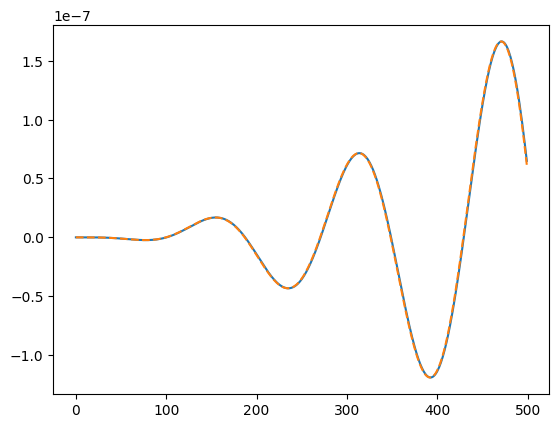

In [ ]:
# Luckily, orbital polarizations also agree :D
plt.plot(
    obs.values[:500, 0], label="TB"
)

plt.plot(
    obs2.values[:500, 0], label="L", linestyle="dashed"
)

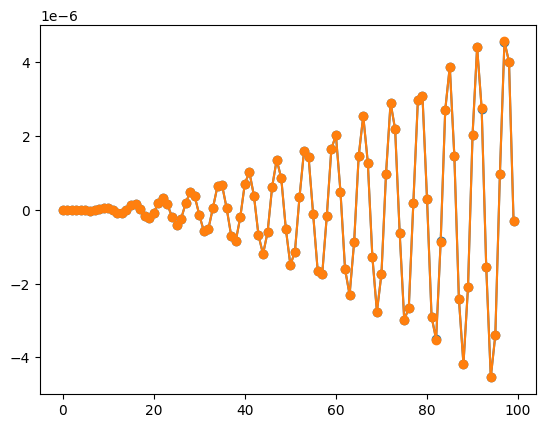

In [ ]:
Px = []
for state in l.states:
    Px.append(l._orbital_polarisation_with_shape(l._current_density(state))[0])

Px = np.array(Px)

plt.plot(
    Px[:100] / 20.784, "o-", label="L direct"
)
plt.plot(
    -obs2.values[:2500:25, 0] / 0.74, "o-", label="L observable"
)

# Also, the lattice implementation with a direct loop sum agrees with the vectorized observable implementation
# up to a sign in the current density that needs to be investigated further. It is also wrong in the report!!

In [23]:
from lattice import * 
from typing import Optional
from numpy.typing import NDArray


def triple_fold_simulation_lattice(Lx, Ly, omega, decay_time, data_folder):
    T = 2 * np.pi / omega
    cycles = 10
    field_gen = FieldAmplitudeGenerator.ramped_oscillation(amplitude=1e-3, omega=omega, ramp_width=12*np.pi)

    geometry = HexagonalLatticeGeometry((Lx, Ly))
    edges = np.array(geometry.edges)


    substeps = 25

    params = SimulationParameters(
        t_hop=-1.0,
        E_amplitude=field_gen,
        E_direction=np.array([0, 1]),
        h=1.0/omega,
        T=cycles*T + 12*np.pi,
        substeps=substeps,
        initial_occupation=0.5
    )


    l = Lattice2D(geometry, params)

    orb_pol_obs = OrbitalPolarisationWithShape(
        site_positions=np.array([geometry.site_to_position(i) for i in range(l.N)]),
        curl_origin=geometry.curl_origin,
        N=l.N,
        n_steps=(params.substeps * int(params.T / params.h)) +1, 
        cell_anchor_sites=np.array(geometry.get_curl_sites()),
        cell_path_offsets=np.array([(0, 1), (1, 2), (2, l.Lx + 2), (l.Lx + 2, l.Lx + 1), (l.Lx + 1, l.Lx), (l.Lx, 0)]),
        t_hop=params.t_hop,
        m=0.72, # electron mass in natural units
        a_nn=1.0,
        Area=len(geometry.get_curl_sites())*3*np.sqrt(3)/2,
        sample_every=2*(substeps//25),
    )

    l.evolve(
        decay_time=decay_time,
        observables=[orb_pol_obs],
        use_gpu=False,
    )

    t_vals = np.linspace(0, cycles*T+12*np.pi, len(orb_pol_obs.values))
    E_vals = np.array([field_gen(t) for t in t_vals])

    return {
        "Lx": Lx,
        "Ly": Ly,
        "omega": omega,
        "decay_time": decay_time,
        "h": params.h,
        "substeps": substeps,
        "E_time": t_vals,
        "E_amplitude": E_vals,
        "orb_pol_values": orb_pol_obs.values,
    }

In [ ]:
def triple_fold_simulation(Lx, Ly, omega, decay_time, data_folder):
    T = 2 * np.pi / omega
    cycles = 10

    H = tb.LinearFieldHamiltonian(
        tb.HoneycombLatticeGeometry(Lx=Lx, Ly=Ly),
        tb.RampedACFieldAmplitude(E0=1e-3, omega=omega, T_ramp=12*np.pi, direction=np.array([0.0, 1.0])),
    )

    obs = tb.orbitronics_2d.observables.OrbitalPolarizationHoneycomb(
        H.geometry,
        measurement_stride=1,
    )

    substeps = 25
    orb_pol_obs = tb.OrbitalPolarizationHoneycomb(H.geometry)

    rho = H.ground_state_density_matrix(fermi_level=0.0)
    tb.RK4NeumannSolver().evolve(rho, H, dt=0.06 / omega, total_time=(cycles * T + 12 * np.pi), observables=[orb_pol_obs], tau=decay_time)


    return {
        "Lx": Lx,
        "Ly": Ly,
        "omega": omega,
        "decay_time": decay_time,
        "substeps": substeps,
        "field": H.field_amplitude,
        "obs": orb_pol_obs,
    }

In [25]:
Lx_range = [11, 19]
Ly_range = [20, 40]
omega_range = [0.5, 1.0, 2.0]
rows = []
rows_l = []

for Lx in Lx_range:
    for Ly in Ly_range:
        for omega in omega_range:
            print(f"Lx: {Lx}, Ly: {Ly}, omega: {omega}")
            rows.append(triple_fold_simulation(Lx, Ly, omega, 14.0, "../data"))
            rows_l.append(triple_fold_simulation_lattice(Lx, Ly, omega, 14.0, "../data"))

Lx: 11, Ly: 20, omega: 0.5
Area: 223.43455417638518
Area: 223.43455417638518
Calculating eigenvalues at t=0...


  0%|          | 0/1361 [00:00<?, ?it/s]

100%|██████████| 1361/1361 [00:04<00:00, 329.81it/s]


Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 2042/2042 [00:12<00:00, 169.42it/s]


Lx: 11, Ly: 20, omega: 1.0
Area: 223.43455417638518
Area: 223.43455417638518
Calculating eigenvalues at t=0...


100%|██████████| 1675/1675 [00:05<00:00, 318.85it/s]


Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 2513/2513 [00:15<00:00, 167.47it/s]


Lx: 11, Ly: 20, omega: 2.0
Area: 223.43455417638518
Area: 223.43455417638518
Calculating eigenvalues at t=0...


100%|██████████| 2303/2303 [00:06<00:00, 370.15it/s]


Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 3455/3455 [00:20<00:00, 169.02it/s]


Lx: 11, Ly: 40, omega: 0.5
Area: 457.2614131981836
Area: 457.2614131981836
Calculating eigenvalues at t=0...


 94%|█████████▍| 1277/1361 [00:16<00:01, 77.41it/s]


KeyboardInterrupt: 

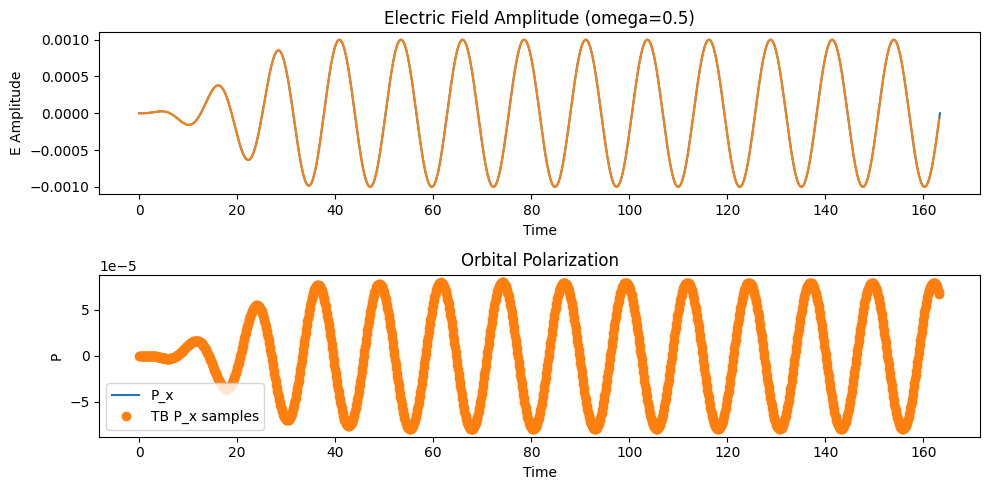

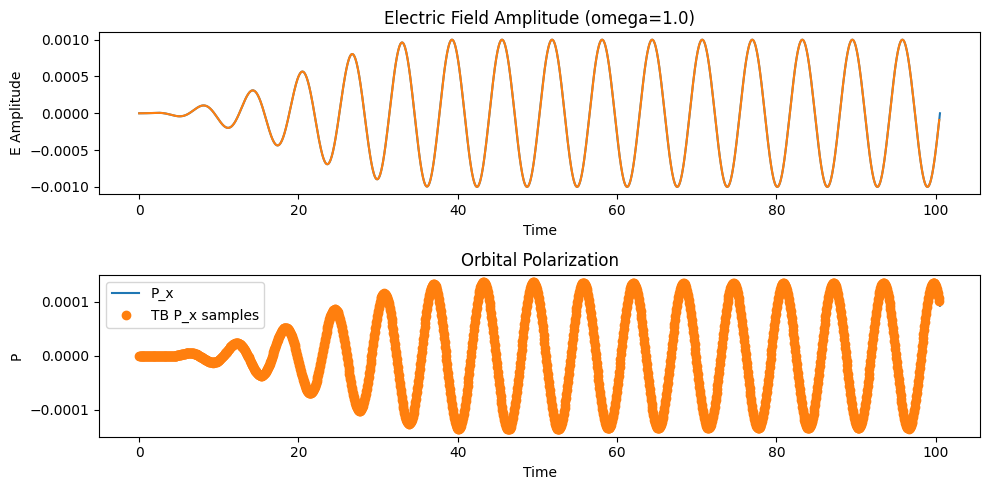

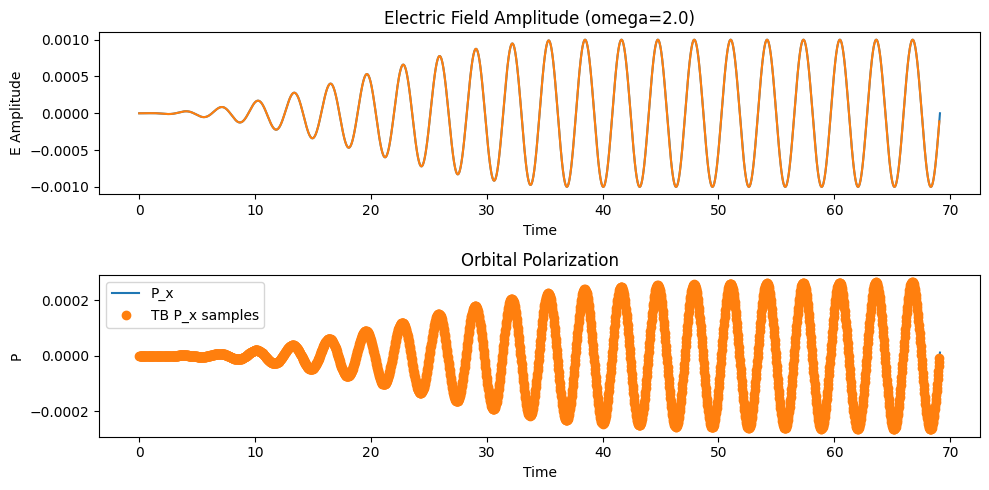

In [26]:
for row, row_l in zip(rows, rows_l):
    omega = row["omega"]
    assert omega == row_l["omega"]
    t_vals = row_l["E_time"]
    E_vals = row_l["E_amplitude"]
    orb_pol_vals = row_l["orb_pol_values"]
    obs = row["obs"]

    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(t_vals, E_vals)
    plt.plot(obs.measurement_times, row["field"].amplitude_at_time(obs.measurement_times), label="TB field samples")
    plt.title(f"Electric Field Amplitude (omega={omega})")
    plt.xlabel("Time")
    plt.ylabel("E Amplitude")

    plt.subplot(2,1,2)
    plt.plot(t_vals, orb_pol_vals[:,0], label="P_x")
    plt.plot(obs.measurement_times, obs.values[:,0], 'o', label="TB P_x samples")
    plt.title("Orbital Polarization")
    plt.xlabel("Time")
    plt.ylabel("P")
    plt.legend()

    plt.tight_layout()
    plt.show()
    print("="*20)

Lx: 11, Ly: 20, omega: 0.5, ohc: 0.2490848368472494
Lx: 11, Ly: 20, omega: 1.0, ohc: 0.8467676999803412
Lx: 11, Ly: 20, omega: 2.0, ohc: 3.305412461010076


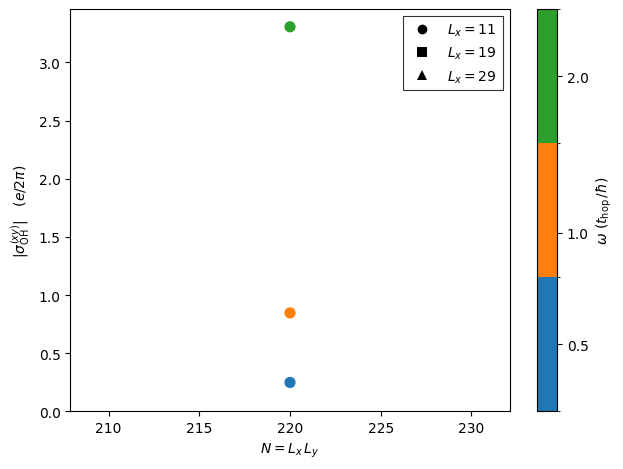

In [29]:
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import pandas as pd

ohc_rows = []

for row in rows:
    t_eq = (2*np.pi / row["omega"]) * 5 + 12 * np.pi
    try:
        obs = row["obs"]
        start_index = np.searchsorted(obs.measurement_times, t_eq)
        field = row["field"]
        orb_current = (np.diff(obs.values[:, 0]) / np.diff(obs.measurement_times))[start_index - 1 :]
        E = field.amplitude_at_time(obs.measurement_times[start_index : -1])
        #plt.plot(E)
        #plt.show()
        ohc = tb.orbitronics_2d.ohc.ohc(orb_current, E, dt=obs.measurement_times[1] - obs.measurement_times[0], omega = row["omega"])
        ohc_rows.append(
            {
                "Lx": row["Lx"],
                "Ly": row["Ly"],
                "omega": row["omega"],
                "ohc_abs": abs(ohc),
                "ohc_angle": np.angle(ohc),
            }
        )
        #plt.plot(orb_current, label="J")
        #plt.plot(E * abs(ohc) / (2*np.pi), label="E")
        #plt.legend()
        #plt.show()
        print(f"Lx: {row['Lx']}, Ly: {row['Ly']}, omega: {row['omega']}, ohc: {abs(ohc)}")
    except KeyError:
        E_val = row["E_amplitude"]
        times = row["E_time"]
        obs = row["orb_pol_values"]
        start_index = np.searchsorted(times, t_eq)
        orb_current = (np.diff(obs[:, 0]) / np.diff(times))[start_index - 1 :]
        E = E_val[start_index : -1]
        #plt.plot(E)
        #plt.show()
        ohc = tb.orbitronics_2d.ohc.ohc(orb_current, E, dt=times[1] - times[0], omega = row["omega"])
        ohc_rows.append(
            {
                "Lx": row["Lx"],
                "Ly": row["Ly"],
                "omega": row["omega"],
                "ohc_abs": abs(ohc),
                "ohc_angle": np.angle(ohc),
            }
        )

ohc_df = pd.DataFrame(ohc_rows)

omegas = np.sort(ohc_df["omega"].unique())
N = len(omegas)

cmap = plt.get_cmap("tab10", 3*N)
if N == 1:
    bounds = np.array([omegas[0] - 0.1, omegas[0] + 0.1])
else:
    mids = (omegas[:-1] + omegas[1:]) / 2
    first = omegas[0] - (mids[0] - omegas[0])
    last = omegas[-1] + (omegas[-1] - mids[-1])
    bounds = np.concatenate(([first], mids, [last]))
norm = BoundaryNorm(bounds, N)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig = plt.gcf()

cb = fig.colorbar(sm, ax=plt.gca(), ticks=omegas)
cb.ax.set_yticklabels([str(o) for o in omegas])
cb.set_label("$\\omega\\ (t_\\mathrm{hop}\\,/\\hbar)$")

# plot ohc_abs vs system size (Lx*Ly), with markers based on Lx and colors based on omega
markers = ['o', 's', '^']
colors = plt.cm.viridis(np.linspace(0, 1, len(ohc_df["Ly"].unique())))

for i, lx in enumerate(sorted(ohc_df["Lx"].unique())):
    lx_data = ohc_df[ohc_df["Lx"] == lx]
    plt.scatter(
        lx_data["Ly"] * lx_data["Lx"],
        lx_data["ohc_abs"],
        marker=markers[i],
        c=lx_data["omega"],
        s=50,
        label=f'Lx={lx}',
        cmap=cmap,
        norm=norm,
        alpha=1
    )

import matplotlib.lines as mlines

s = mlines.Line2D([], [], color='black', marker='s', ls='', label='$L_x=19$', markeredgewidth=0, markersize=7)
o = mlines.Line2D([], [], color='black', marker='o', ls='', label='$L_x=11$', markeredgewidth=0, markersize=7)
v = mlines.Line2D([], [], color='black', marker='^', ls='', label='$L_x=29$', markeredgewidth=0, markersize=7)

legend = plt.legend(handles=[o,s, v], fancybox=False, edgecolor='black')
legend.get_frame().set_linewidth(0.8)

plt.ylim(bottom=0)
plt.xlabel("$N=L_x\\, L_y$")
plt.ylabel("$|\\sigma_\\mathrm{OH}^{(xy)}| \\quad (e/2\\pi)$")
plt.tight_layout()
plt.show()

In [28]:
ohc_df

,Lx,Ly,omega,ohc_abs,ohc_angle
0,11,20,0.5,0.242329,-2.570826
1,11,20,1.0,0.824297,-2.384728
2,11,20,2.0,3.237257,1.568274


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45
 3.5  3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15
 4.2  4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85
 4.9  4.95 5.   5.05 5.1  5.15 5.2  5.25 5.3  5.35 5.4  5.45 5.5  5.55
 5.6  5.65 5.7  5.75 5.8  5.85 5.9  5.95 6.   6.05 6.1  6.15 6.2  6.25
 6.3  6.35 6.4  6.45 6.5  6.55 6.6  6.65 6.7  6.75 6.8  6.85 6.9  6.95
 7.   7.05 7.1  7.15 7.2  7.25 7.3  7.35 7.4  7.45 7.5  7.55 7.6  7.65
 7.7  7.75 7.8  7.85 7.9  7.95 8.   8.05 8.1  8.15 8.2  8.25 8.3  8.35
 8.4  8.45 8.5  8.55 8.6  8.65 8.7  8.75 8.8  8.85 8.9  8.95 9.   9.05
 9.1  9.15 9.2  9.25 9.3  9.35 9.4  9.45 9.5  9.55 9.6  9.65 9.7  9.75
 9.8  

np.complex128(6.573136091215503e-05+0.010163233792807393j)

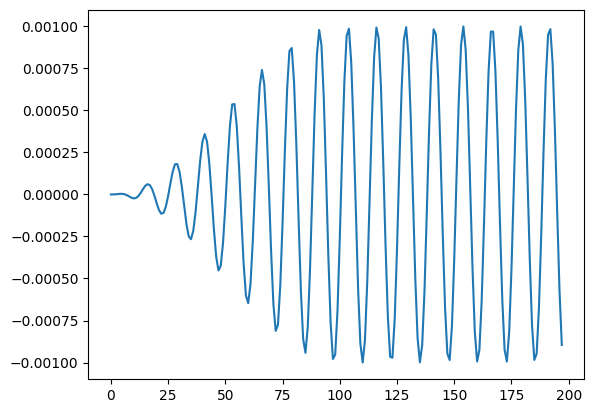

In [ ]:
import matplotlib.pyplot as plt

t_eq = 0
start_index = np.searchsorted(obs.measurement_times, t_eq)
orb_current = (np.diff(obs.values[:, 0]) / np.diff(obs.measurement_times))[start_index - 1 :]
E = H.field_amplitude.at_time(obs.measurement_times[start_index : -1])

print(obs.measurement_times[start_index: -1])

plt.plot(E)

tb.orbitronics_2d.ohc.ohc(orb_current, E, dt=obs.measurement_times[1] - obs.measurement_times[0], omega = 10)

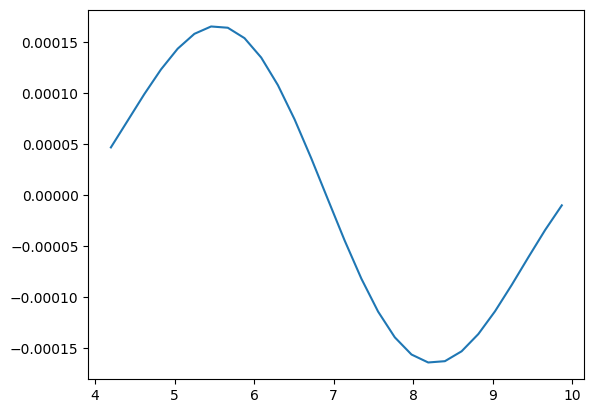

In [ ]:
Px = obs.values[:, 0]
import matplotlib.pyplot as plt

plt.plot(obs.measurement_times, Px)
plt.show()

In [ ]:
obs.values[-20:]

array([[ 5.99589538e-02, -1.37144271e-16],
       [ 6.43237583e-02, -1.45713805e-16],
       [ 6.46448160e-02, -1.59554458e-16],
       [ 6.11228303e-02, -1.75044318e-16],
       [ 5.42387041e-02, -1.86411159e-16],
       [ 4.46639140e-02, -1.64118318e-16],
       [ 3.31741956e-02, -2.08320238e-16],
       [ 2.05794186e-02, -1.99249597e-16],
       [ 7.67263241e-03, -2.19185972e-16],
       [-4.80543521e-03, -1.55399711e-16],
       [-1.61928133e-02, -1.27702542e-16],
       [-2.59297315e-02, -1.33960013e-16],
       [-3.35827993e-02, -1.53071784e-16],
       [-3.88696192e-02, -1.31809697e-16],
       [-4.16788619e-02, -1.48948765e-16],
       [-4.20780598e-02, -1.48124162e-16],
       [-4.03029961e-02, -1.71035456e-16],
       [-3.67281666e-02, -1.42941849e-16],
       [-3.18235106e-02, -1.52221862e-16],
       [-2.61046381e-02, -1.74099181e-16]])

In [ ]:
t = 1
H1 = l.H(t).real
H2 = H.at_time(t).toarray().real

plt.imshow(H2)
plt.colorbar()
plt.show()

plt.imshow(l.H(t).real)
plt.colorbar()
plt.show()

print(np.sum(np.abs(H1-H2))<1e-15)

In [ ]:
print(l.geometry.get_curl_sites())
print(H.geometry.bravais_site_indices)

```python
H = LinearFieldHamiltonian(
    geometry = HoneycombLattice(Lx = .., Ly = ..),
    field = RampedACField(
        amplitude = ..,
        angular_frequency = ..,
        ramp_time = ..,
        direction = [1, 0],
    ),
    t_hop = .., (default 1?)
)



observables = [
    tb.observable.GlobalOrbitalCurrent(...),
    tb.observable.SiteDensities(...),
    tb.observable.BondCurrents(...),
    tb.observable.PlaquetteOAM(
        geometry,
        electron_mass = ...,
        measurement_start_time = ..,
        measurement_end_time = ..,
        n_timesteps_between_measurements = ..,
    ),
]

rho = H.ground_state_density_matrix(fermi_energy = 0)

RK4solver = tb.RK4NeumannSolver()
RK4solver.evolve(
    rho,
    H,
    total_time = ..,
    dt = ..,
    observables = [...],
)

animations.save_system_animation("test.mp4", geometry, densities, bond_currents, plaquette_oam, fps=...)
```